In [13]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [15]:
testpath= r'C:\Users\Admin\Downloads\archive (1)\modified-dataset\test'
trainpath= r'C:\Users\Admin\Downloads\archive (1)\modified-dataset\train'
validpath = r'C:\Users\Admin\Downloads\archive (1)\modified-dataset\val'

In [16]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [17]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [18]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [19]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


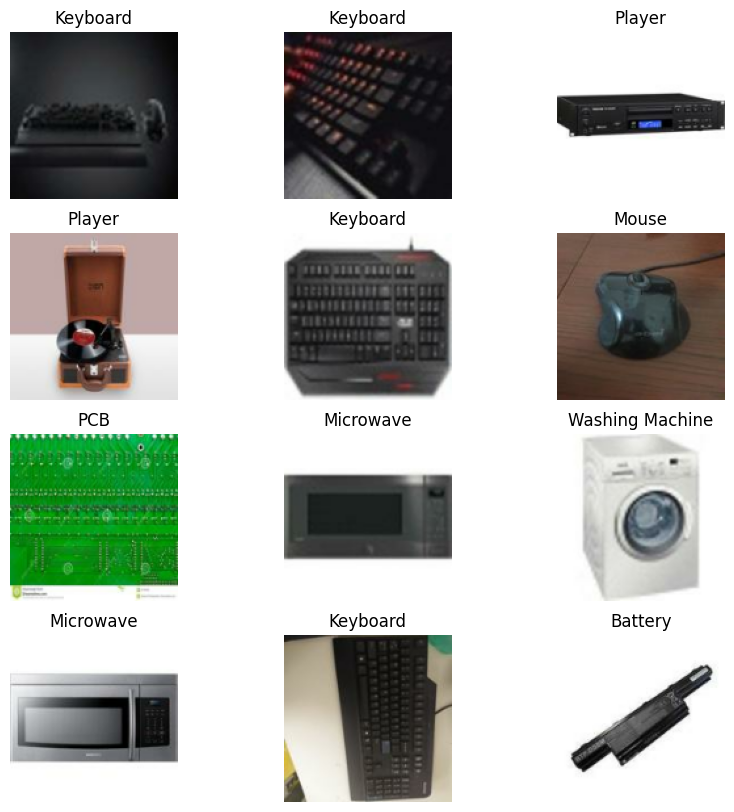

In [67]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


In [86]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Create data for plotting
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

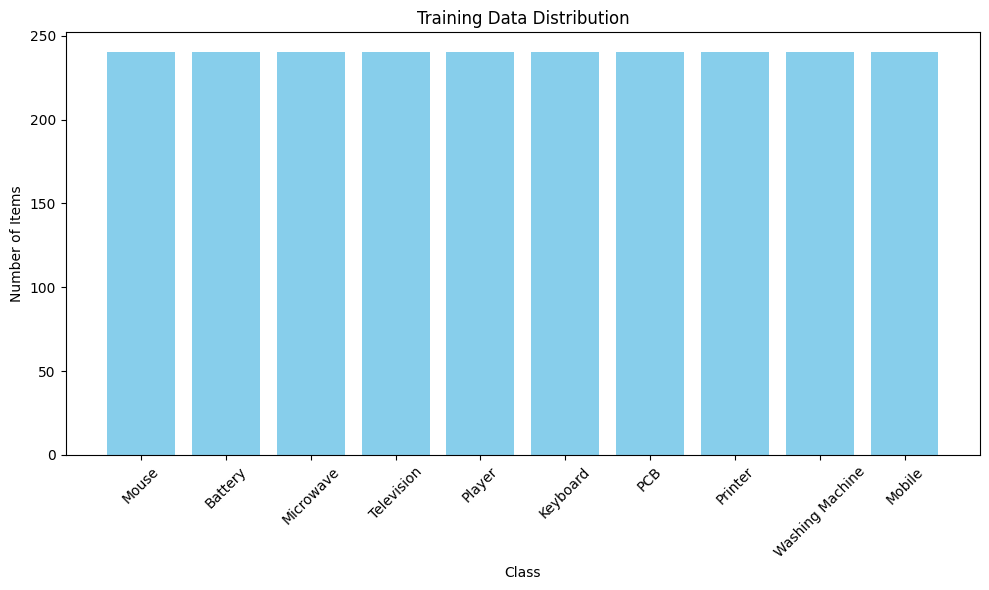

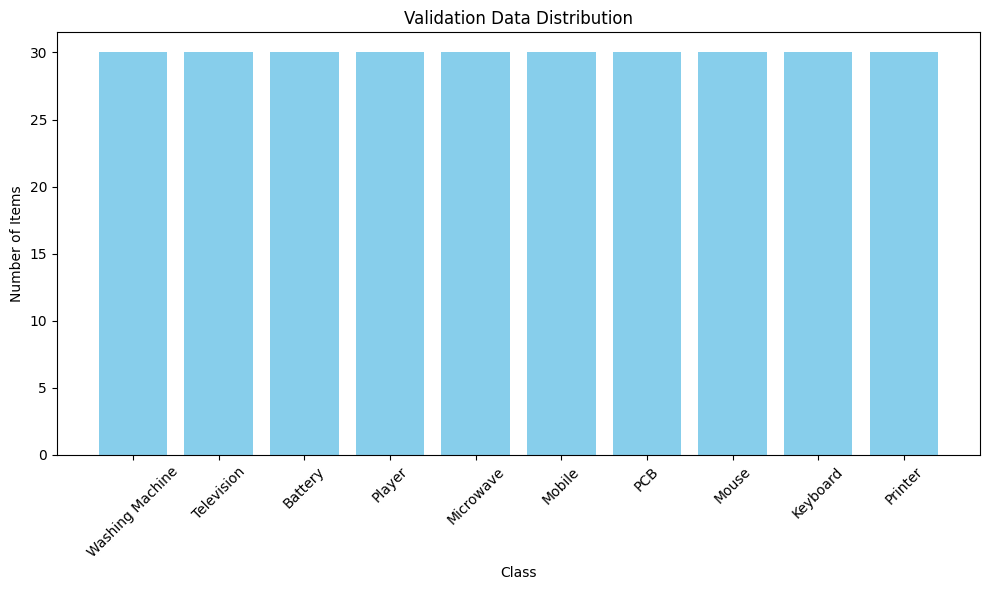

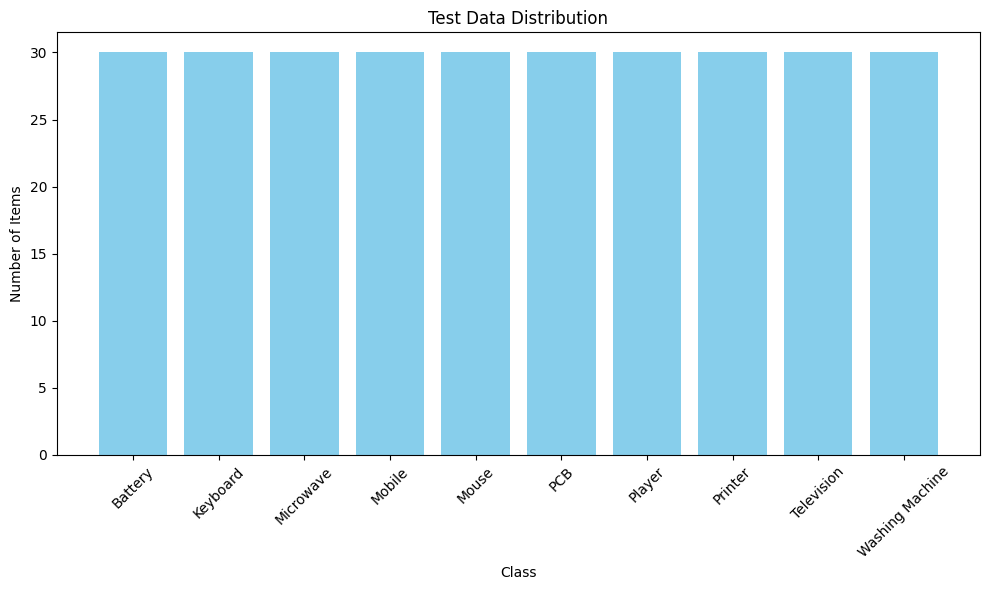

In [87]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [88]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [89]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [91]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [92]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - Accuracy: 0.3045 - loss: 2.0424 - val_Accuracy: 0.8100 - val_loss: 1.0718
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - Accuracy: 0.7856 - loss: 0.9745 - val_Accuracy: 0.9267 - val_loss: 0.4668
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - Accuracy: 0.8618 - loss: 0.5141 - val_Accuracy: 0.9400 - val_loss: 0.2893
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - Accuracy: 0.9109 - loss: 0.3192 - val_Accuracy: 0.9500 - val_loss: 0.2193
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - Accuracy: 0.9327 - loss: 0.2470 - val_Accuracy: 0.9600 - val_loss: 0.1858
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - Accuracy: 0.9397 - loss: 0.2082 - val_Accuracy: 0.9600 - val_loss: 0.1745
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - Accuracy: 0.9453 - loss: 0.1728 - val_Accuracy: 0.9567 - val_loss: 0.1789
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - Accuracy: 0.9761 - loss: 0.1117 - val_Accuracy: 0.9500 - v

In [93]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [94]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [95]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

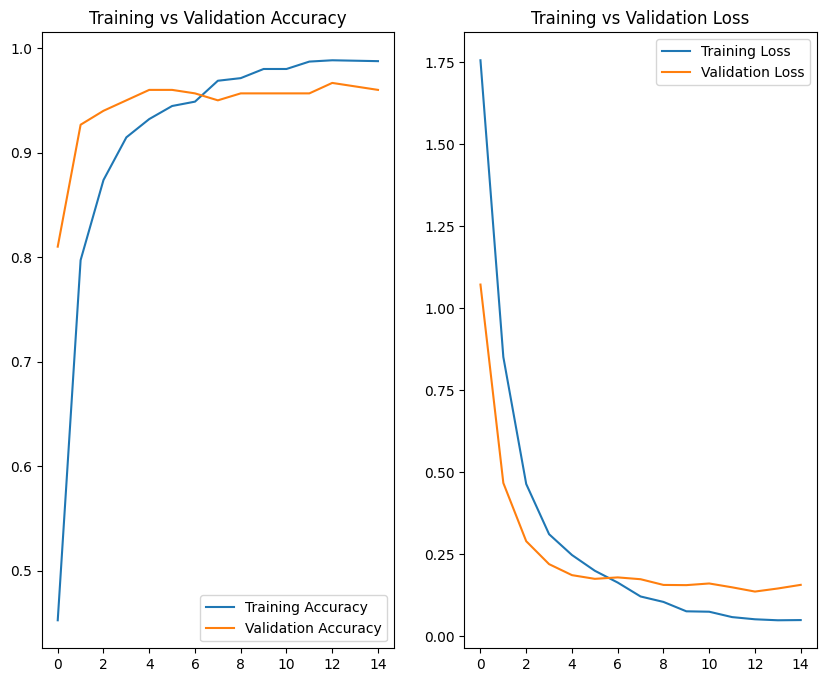

In [96]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [97]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - Accuracy: 0.9678 - loss: 0.1488
Test accuracy is0.9700, Test loss is 0.1294


In [98]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))                     


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 2 28  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 1  0  0  0  0 29  0  0  0  0]
 [ 0  0  1  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  2  0  0  0  1  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       1.00      0.93      0.97        30
           2       0.91      0.97      0.94        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       0.97      0.97      0.97        30
           6       0.97      0.97      0.97        30
           7       0.97      1.00      0.98        30
           8       1.00      0.90      0.95        30
           9       1.00      1.00      1.00        30

    accuracy                      

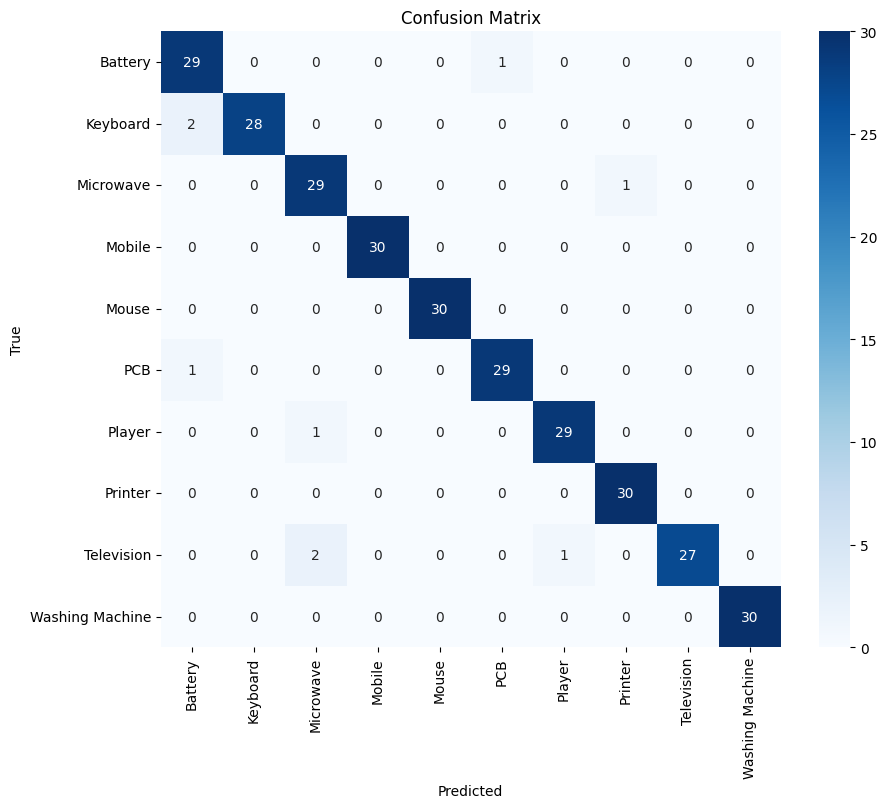

In [99]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot
